In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
import cv2 as cv
from PIL import Image
import natsort
import random
from sklearn.model_selection import train_test_split
from keras_unet.utils import plot_segm_history
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras.callbacks import ModelCheckpoint
from keras_unet.models import custom_unet
from keras_unet.utils import plot_imgs
from keras_unet.utils import get_augmented
from skimage.io import imread, imshow


2022-07-13 14:37:33.149874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/listic/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-13 14:37:33.149941: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## Load data

In [2]:
dir  = os.getcwd()
dir,__ = os.path.split(dir)
patchSize = 160
os.chdir(dir + f'/data/Non_supervise/')

trainPath = dir + f'/data/Non_supervise/Imgs/'
truthPathPng = dir + f'/data/Non_supervise/Masques/maskPNG'

trainPath = glob.glob(trainPath+'*.jpg')
truthPathPng = glob.glob(truthPathPng+'*.png')

trainPath = natsort.natsorted(trainPath)
truthPathPng = natsort.natsorted(truthPathPng)

temp = list(zip(trainPath, truthPathPng))
random.shuffle(temp)
random.Random(1337).shuffle(trainPath)
random.Random(1337).shuffle(truthPathPng)

for train, truthPng in zip(trainPath[::900], truthPathPng[::900]):
        print(train+" | "+truthPng)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cut = int(len(trainPath)/2)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

imgs_list = []
masks_list = []
for image, mask in zip(trainPath[:cut], truthPathPng[:cut]):
    imgs_list.append(np.array(Image.open(image)))
    masks_list.append(np.array(Image.open(mask)))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

/home/listic/Documents/data/seuillage/uNet/160_full/train/4233.jpg | /home/listic/Documents/data/seuillage/uNet/160_full/truth/4233.png
/home/listic/Documents/data/seuillage/uNet/160_full/train/5619.jpg | /home/listic/Documents/data/seuillage/uNet/160_full/truth/5619.png
/home/listic/Documents/data/seuillage/uNet/160_full/train/12040.jpg | /home/listic/Documents/data/seuillage/uNet/160_full/truth/12040.png
/home/listic/Documents/data/seuillage/uNet/160_full/train/1825.jpg | /home/listic/Documents/data/seuillage/uNet/160_full/truth/1825.png
/home/listic/Documents/data/seuillage/uNet/160_full/train/5176.jpg | /home/listic/Documents/data/seuillage/uNet/160_full/truth/5176.png
/home/listic/Documents/data/seuillage/uNet/160_full/train/11038.jpg | /home/listic/Documents/data/seuillage/uNet/160_full/truth/11038.png
/home/listic/Documents/data/seuillage/uNet/160_full/train/11282.jpg | /home/listic/Documents/data/seuillage/uNet/160_full/truth/11282.png
/home/listic/Documents/data/seuillage/uNet

## Get data into correct shape, dtype and range (0.0-1.0)

In [3]:
print(imgs_np.max(), masks_np.max())

x = np.asarray(imgs_np, dtype=np.float32)/imgs_np.max()
y = np.asarray(masks_np, dtype=np.float32)/masks_np.max()

print(x.max(), y.max())
print(x.shape, y.shape)

y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

#  Train/val split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

255 255
1.0 1.0
(6300, 160, 160, 3) (6300, 160, 160)
(6300, 160, 160, 3) (6300, 160, 160, 1)
x_train:  (4410, 160, 160, 3)
y_train:  (4410, 160, 160, 1)
x_val:  (1890, 160, 160, 3)
y_val:  (1890, 160, 160, 1)


## Prepare train generator with data augmentation

In [23]:
train_gen = get_augmented(
    x_train, y_train, batch_size=5,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

sample_batch = next(train_gen)
xx, yy = sample_batch

## Initialize network

In [5]:
input_shape = x_train[0].shape
print(input_shape)

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=4)
    
model.summary()

(160, 160, 3)


2022-07-13 14:38:08.308975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/listic/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-13 14:38:08.308998: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-13 14:38:08.309014: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lsta102): /proc/driver/nvidia/version does not exist
2022-07-13 14:38:08.309787: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Compile + train

In [6]:
os.chdir(dir + f'Modèles_trained/Segmentation_Unet')
model_filename = 'new.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    learning_rate=0.01,
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,)

model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded])

In [24]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=15,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint])

Epoch 1/15


/tmp/ipykernel_242630/332414310.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - ETA: 0s - loss: 0.2974 - iou: 0.6861 - iou_thresholded: 0.7678

2022-07-13 16:13:55.073961: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 580608000 exceeds 10% of free system memory.



Epoch 1: val_loss did not improve from 0.22988
100/100 [==============================] - 169s 2s/step - loss: 0.2974 - iou: 0.6861 - iou_thresholded: 0.7678 - val_loss: 0.2460 - val_iou: 0.7640 - val_iou_thresholded: 0.8317
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 0.3052 - iou: 0.6946 - iou_thresholded: 0.8007
Epoch 2: val_loss did not improve from 0.22988
100/100 [==============================] - 165s 2s/step - loss: 0.3052 - iou: 0.6946 - iou_thresholded: 0.8007 - val_loss: 0.2602 - val_iou: 0.7321 - val_iou_thresholded: 0.8472
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.3154 - iou: 0.6724 - iou_thresholded: 0.7767
Epoch 3: val_loss did not improve from 0.22988
100/100 [==============================] - 165s 2s/step - loss: 0.3154 - iou: 0.6724 - iou_thresholded: 0.7767 - val_loss: 0.2856 - val_iou: 0.7530 - val_iou_thresholded: 0.8270
Epoch 4/15
100/100 [==============================] - ETA: 0s - loss: 0.3098 - iou: 0.6867

## Plot training history

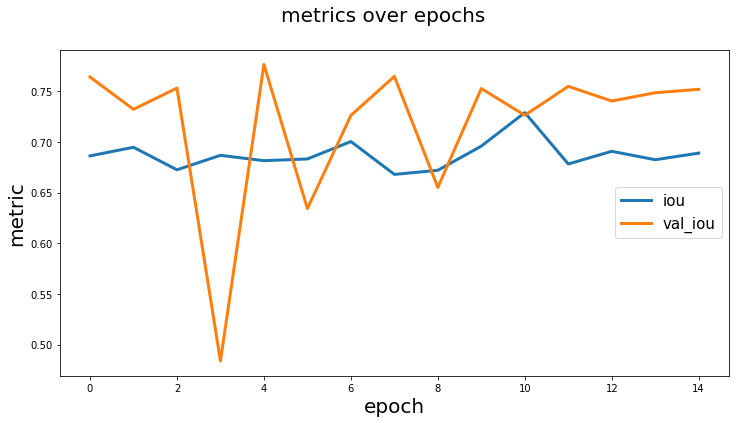

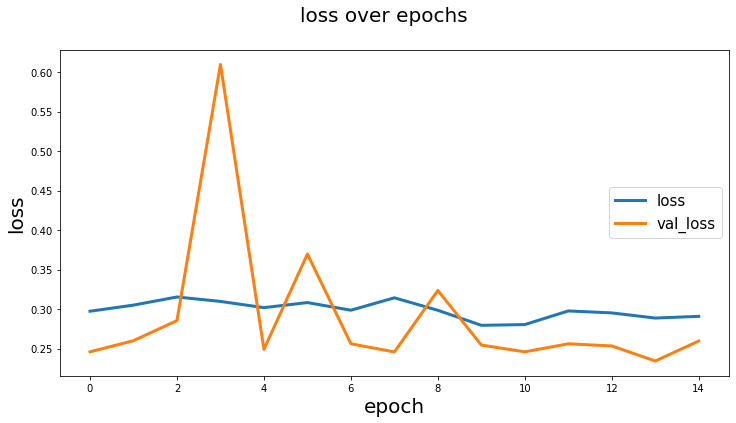

In [25]:
plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [26]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)


plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=40, figsize=2)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '15ep_150step_V10.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Exploitation du modèle

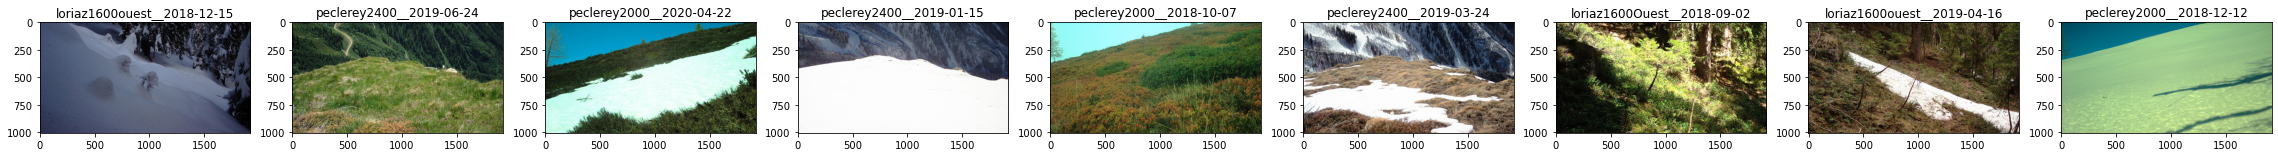

In [10]:
dir  = os.getcwd()
dir,__ = os.path.split(dir)
imgs_path = os.listdir(dir + '/data/Ref/Imgs')
imgs_path.sort()

imgs = []
for i in imgs_path:
    imgs.append(imread(f"{dir}/data/Ref/Imgs/{i}"))

fig, axs = plt.subplots(1, 9, figsize = (40, 10))
for i in range(len(imgs)):
    axs[i].imshow(imgs[i])
    axs[i].set_title(imgs_path[i][:-17])
    axs[i].set_axis_off()
plt.show()

In [11]:
def segmentedPatch(img, trained_model, patchSize = 160):
    """
    entrée: image à segmenter, patchSize = taille du patch à classifier 
    sortie: masque de segmentation
    """

    segmented = np.zeros((1008,1920))# *False
    
    for j in range(0, len(img[0])-patchSize-1, patchSize):
        for i in range(0, len(img)-patchSize-1, patchSize):
            patch = img[i:i+patchSize,j:j+patchSize]
            patch = patch[None, :, :, :]
            sortie = trained_model.predict(patch)
            # segmented[i:i+patchSize,j:j+patchSize] = np.logical_or(segmented[i:i+patchSize,j:j+patchSize], np.squeeze(sortie))
            res = np.squeeze(sortie)
            segmented[i:i+patchSize,j:j+patchSize] = np.where(res>0.1, 1, 0)
            # segmented[i:i+patchSize,j:j+patchSize] = res

    return segmented

  0%|          | 0/9 [00:00<?, ?it/s]

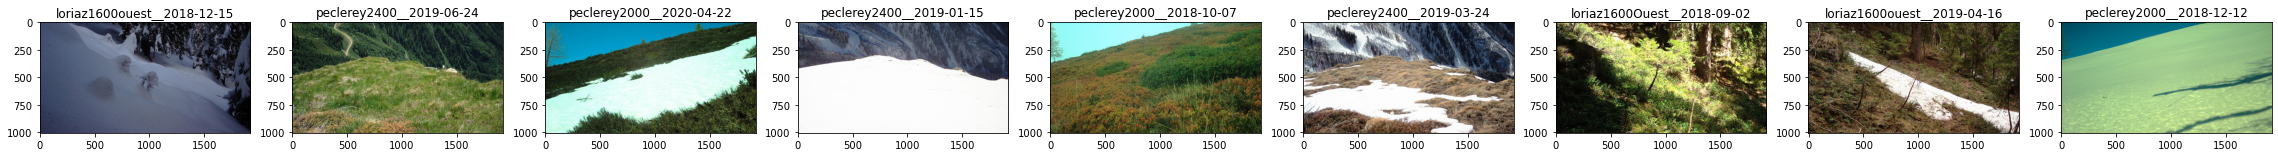

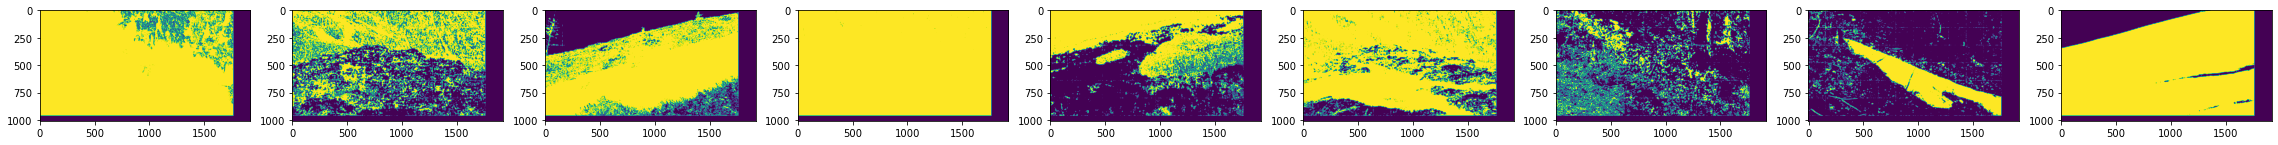

In [26]:

import tensorflow as tf

input_shape = (160, 160, 3)

mod = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=5
)


mod_filename = f'/home/listic/Documents/data/seuillage/uNet/trainedModels/{model_filename}'
# mod_filename = f'/home/listic/Documents/data/seuillage/uNet/trainedModels/{model_filename}'
mod.load_weights(mod_filename)

from tqdm.notebook import tqdm

sortie = []
for im in tqdm(imgs):
    sortie.append(segmentedPatch(im, mod, patchSize = 160))

fig, axs = plt.subplots(1, 9, figsize = (40, 10))
for i in range(len(imgs)):
    axs[i].imshow(imgs[i])
    axs[i].set_title(imgs_path[i][:-17])
plt.show()

fig, axs = plt.subplots(1, 9, figsize = (40, 10))
for i in range(len(sortie)):
    axs[i].imshow(sortie[i])
plt.show()

# test / temp

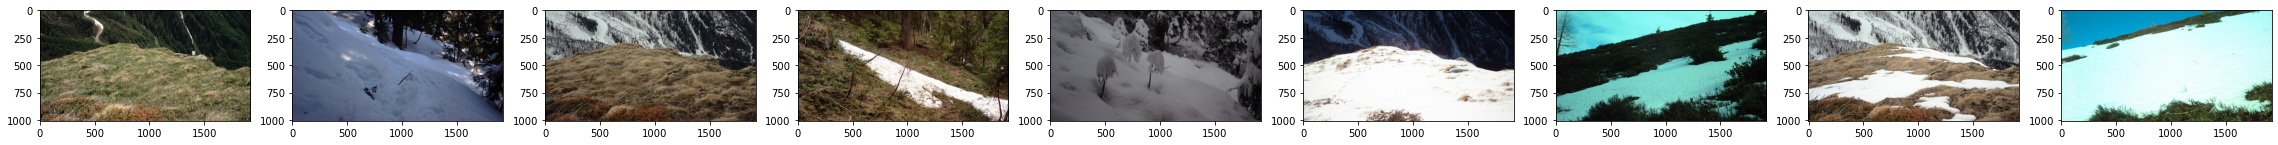

  0%|          | 0/9 [00:00<?, ?it/s]

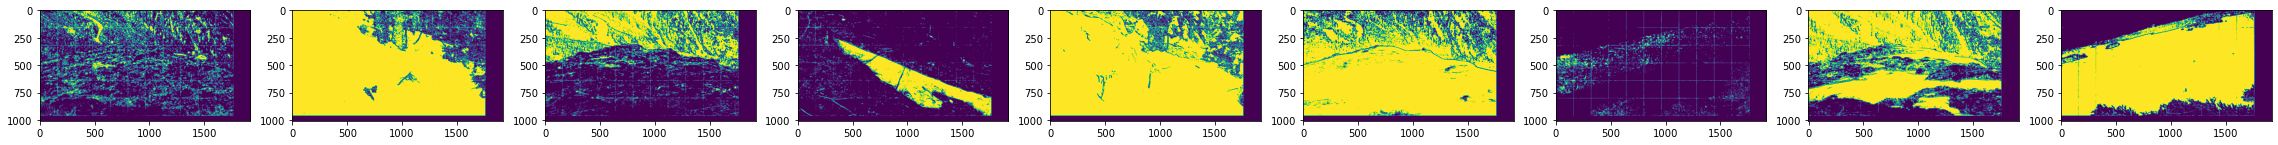

In [28]:
def segmentedPatch(img, trained_model, patchSize = 160):
    """
    entrée: image à segmenter, patchSize = taille du patch à classifier 
    sortie: masque de segmentation
    """

    segmented = np.zeros((1008,1920))# *False
    
    for j in range(0, len(img[0])-patchSize-1, patchSize):
        for i in range(0, len(img)-patchSize-1, patchSize):
            patch = img[i:i+patchSize,j:j+patchSize]
            patch = patch[None, :, :, :]
            sortie = trained_model.predict(patch)
            # segmented[i:i+patchSize,j:j+patchSize] = np.logical_or(segmented[i:i+patchSize,j:j+patchSize], np.squeeze(sortie))
            res = np.squeeze(sortie)
            segmented[i:i+patchSize,j:j+patchSize] = np.where(res>0.1, 1, 0)
            # segmented[i:i+patchSize,j:j+patchSize] = res

    return segmented
os.chdir('/home/listic/Documents/data/seuillage/uNet/temp')
from tqdm.notebook import tqdm

imgs_path = os.listdir()
imgs = []
for i in imgs_path:
    imgs.append(cv.cvtColor(cv.imread(i, 1), cv.COLOR_BGR2RGB))
    
fig, axs = plt.subplots(1, 9, figsize = (40, 10))
for i in range(len(imgs)):
    axs[i].imshow(imgs[i])
    axs[i].set_title(imgs_path[i][:-17])
plt.show()

sortie = []
for im in tqdm(imgs):
    sortie.append(segmentedPatch(im, model, patchSize = 160))


fig, axs = plt.subplots(1, 9, figsize = (40, 10))
for i in range(len(sortie)):
    axs[i].imshow(sortie[i])
plt.show()
